This is a simple example of UKF.

Original code from the python book : https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python
        

In EKF the state distribution is propagated analytically through the first-order linearization of the nonlinear system due to which, the posterior mean and covariance could be corrupted. The UKF, which is a derivative-free alternative to EKF, overcomes this problem by using a deterministic sampling approach [9]. The state distribution is represented using a minimal set of carefully chosen sample points, called sigma points. Like EKF, UKF consists of the same two steps: model forecast and data assimilation, except they are preceded now by another step for the selection of sigma points.


The UKF is based on the principle that is easier to approximate a Gaussian distribution than it is to approximate arbitrary nonlinear functions 
Instead of linearizing the functions as is done in the EKF, the UKF uses a set of points and propagates this set through the actual non-linear function. 
These points are chosen such that their mean, covariance and possibly also higher order moments match the Gaussian random variable. The mean and the covariance can be recalculated from the propagated points, yielding more accurate results compared to the ordinary function linearization. 


### Predict Step

The UKF's predict step computes the prior using the process model $f()$. $f()$ is assumed to be nonlinear, so we generate sigma points $\mathcal{X}$ and their corresponding weights $W^m, W^c$
according to some function:

$$\begin{aligned}
\boldsymbol\chi &= \text{sigma-function}(\mathbf x, \mathbf P) \\
W^m, W^c &= \text{weight-function}(\mathtt{n, parameters})\end{aligned}$$

We pass each sigma point through $f(\mathbf x, \Delta t)$. This projects the sigma points forward in time according to the process model, forming the new prior, which is a set of sigma points we name $\boldsymbol{\mathcal Y}$:

$$\boldsymbol{\mathcal{Y}} = f(\boldsymbol{\chi}, \Delta t)$$

We compute the mean and covariance of the prior using the *unscented transform* on the transformed sigma points.  

$$\mathbf{\bar x}, \mathbf{\bar P} = 
UT(\mathcal{Y}, w_m, w_c, \mathbf Q)$$

These are the equations for the unscented transform:

$$\begin{aligned}
\mathbf{\bar x} &= \sum_{i=0}^{2n} w^m_i\boldsymbol{\mathcal Y}_i \\
\mathbf{\bar P} &= \sum_{i=0}^{2n} w^c_i({\boldsymbol{\mathcal Y}_i - \mathbf{\bar x})(\boldsymbol{\mathcal Y}_i-\mathbf{\bar x})^\mathsf{T}} + \mathbf Q
\end{aligned}
$$

This table compares the linear Kalman filter with the Unscented Kalman Filter equations. I've dropped the subscript $i$ for readability.

$$\begin{array}{l|l}
\text{Kalman} & \text{Unscented} \\
\hline 
& \boldsymbol{\mathcal Y} = f(\boldsymbol\chi) \\
\mathbf{\bar x} = \mathbf{Fx} & 
\mathbf{\bar x} = \sum w^m\boldsymbol{\mathcal Y}  \\
\mathbf{\bar P} = \mathbf{FPF}^\mathsf T + \mathbf Q  & 
\mathbf{\bar P} = \sum w^c({\boldsymbol{\mathcal Y} - \mathbf{\bar x})(\boldsymbol{\mathcal Y} - \mathbf{\bar x})^\mathsf T}+\mathbf Q
\end{array}$$

### Update Step

Kalman filters perform the update in measurement space. Thus we must convert the sigma points of the prior into measurements using a measurement function $h(x)$ that you define.

$$\boldsymbol{\mathcal{Z}} = h(\boldsymbol{\mathcal{Y}})$$

We compute the mean and covariance of these points using the unscented transform. The $z$ subscript denotes that these are the mean and covariance of the measurement sigma points.

$$\begin{aligned}
\boldsymbol\mu_z, \mathbf P_z &= 
UT(\boldsymbol{\mathcal Z}, w_m, w_c, \mathbf R) \\
\boldsymbol\mu_z &= \sum_{i=0}^{2n} w^m_i\boldsymbol{\mathcal Z}_i \\
\mathbf P_z &= \sum_{i=0}^{2n} w^c_i{(\boldsymbol{\mathcal Z}_i-\boldsymbol{\mu}_z)(\boldsymbol{\mathcal Z}_i-\boldsymbol{\mu}_z)^\mathsf T} + \mathbf R
\end{aligned}
$$

Next we compute the residual and Kalman gain. The residual of the measurement $\mathbf z$ is trivial to compute:

$$\mathbf y = \mathbf z - \boldsymbol\mu_z$$

To compute the Kalman gain we first compute the [cross covariance](https://en.wikipedia.org/wiki/Cross-covariance) of the state and the measurements, which is defined as: 

$$\mathbf P_{xz} =\sum_{i=0}^{2n} w^c_i(\boldsymbol{\mathcal Y}_i-\mathbf{\bar x})(\boldsymbol{\mathcal Z}_i-\boldsymbol\mu_z)^\mathsf T$$

And then the Kalman gain is defined as

$$\mathbf{K} = \mathbf P_{xz} \mathbf P_z^{-1}$$

If you think of the inverse as a *kind of* matrix reciprocal, you can see that the Kalman gain is a simple ratio which computes:

$$\mathbf{K} \approx \frac{\mathbf P_{xz}}{\mathbf P_z} 
\approx \frac{\text{belief in state}}{\text{belief in measurement}}$$

Finally, we compute the new state estimate using the residual and Kalman gain:

$$\mathbf x = \bar{\mathbf x} + \mathbf{Ky}$$

and the new covariance is computed as:

$$ \mathbf P = \mathbf{\bar P} - \mathbf{KP_z}\mathbf{K}^\mathsf{T}$$

This step contains a few equations you have to take on faith, but you should be able to see how they relate to the linear Kalman filter equations. The linear algebra is slightly different from the linear Kalman filter, but the algorithm is the same Bayesian algorithm we have been implementing throughout the book. 

This table compares the equations of the linear KF and UKF equations.

$$\begin{array}{l|l}
\textrm{Kalman Filter} & \textrm{Unscented Kalman Filter} \\
\hline 
& \boldsymbol{\mathcal Y} = f(\boldsymbol\chi) \\
\mathbf{\bar x} = \mathbf{Fx} & 
\mathbf{\bar x} = \sum w^m\boldsymbol{\mathcal Y}  \\
\mathbf{\bar P} = \mathbf{FPF}^\mathsf T+\mathbf Q  & 
\mathbf{\bar P} = \sum w^c({\boldsymbol{\mathcal Y} - \mathbf{\bar x})(\boldsymbol{\mathcal Y} - \mathbf{\bar x})^\mathsf T}+\mathbf Q \\
\hline 
& \boldsymbol{\mathcal Z} =  h(\boldsymbol{\mathcal{Y}}) \\
& \boldsymbol\mu_z = \sum w^m\boldsymbol{\mathcal{Z}} \\
\mathbf y = \mathbf z - \mathbf{Hx} &
\mathbf y = \mathbf z - \boldsymbol\mu_z \\
\mathbf S = \mathbf{H\bar PH}^\mathsf{T} + \mathbf R & 
\mathbf P_z = \sum w^c{(\boldsymbol{\mathcal Z}-\boldsymbol\mu_z)(\boldsymbol{\mathcal{Z}}-\boldsymbol\mu_z)^\mathsf{T}} + \mathbf R \\ 
\mathbf K = \mathbf{\bar PH}^\mathsf T \mathbf S^{-1} &
\mathbf K = \left[\sum w^c(\boldsymbol{\mathcal Y}-\bar{\mathbf x})(\boldsymbol{\mathcal{Z}}-\boldsymbol\mu_z)^\mathsf{T}\right] \mathbf P_z^{-1} \\
\mathbf x = \mathbf{\bar x} + \mathbf{Ky} & \mathbf x = \mathbf{\bar x} + \mathbf{Ky}\\
\mathbf P = (\mathbf{I}-\mathbf{KH})\mathbf{\bar P} & \mathbf P = \bar{\mathbf P} - \mathbf{KP_z}\mathbf{K}^\mathsf{T}
\end{array}$$

Now in the Initialisation and Predict step we have to choose the sigma points, and this is important for UKF. There is an improved way to choose the sigma points compared to the original paper: 

## Van der Merwe's Scaled Sigma Point Algorithm
This formulation uses 3 parameters to control how the sigma points are distributed and weighted: $\alpha$, $\beta$, and $\kappa$. Before we work through the equations, let's look at an example. I will plot the sigma points on top of a covariance ellipse showing the first and second standard deviations, and scale the points based on  the mean weights.

### Sigma Point Computation

The first sigma point is the mean of the input. This is the sigma point displayed in the center of the ellipses in the diagram above. We will call this $\boldsymbol{\chi}_0$.

$$ \mathcal{X}_0 = \mu$$

For notational convenience we define $\lambda = \alpha^2(n+\kappa)-n$, where $n$ is the dimension of $\mathbf x$. The remaining sigma points are computed as

$$ 
\boldsymbol{\chi}_i = \begin{cases}
\mu + \left[ \sqrt{(n+\lambda)\Sigma}\right ]_{i}& \text{for i=1 .. n} \\
\mu - \left[ \sqrt{(n+\lambda)\Sigma}\right]_{i-n} &\text{for i=(n+1) .. 2n}\end{cases}
$$
The $i$ subscript chooses the i$^{th}$ column vector of the matrix.

In other words, we scale the covariance matrix by a constant, take the square root of it, and ensure symmetry by both adding and subtracting it from the mean. We will discuss how you take the square root of a matrix later.

### Weight Computation

This formulation uses one set of weights for the means, and another set for the covariance. The weights for the mean of $\mathcal{X}_0$ is computed as

$$W^m_0 = \frac{\lambda}{n+\lambda}$$

The weight for the covariance of $\mathcal{X}_0$ is

$$W^c_0 = \frac{\lambda}{n+\lambda} + 1 -\alpha^2 + \beta$$

The weights for the rest of the sigma points $\boldsymbol{\chi}_1 ... \boldsymbol{\chi}_{2n}$ are the same for the mean and covariance. They are

$$W^m_i = W^c_i = \frac{1}{2(n+\lambda)}\;\;\;i=1..2n$$

It may not be obvious why this is 'correct', and indeed, it cannot be proven that this is ideal for all nonlinear problems. But you can see that we are choosing the sigma points proportional to the square root of the covariance matrix, and the square root of variance is standard deviation. So, the sigma points are spread roughly according to $\pm 1\sigma$ times some scaling factor. There is an $n$ term in the denominator, so with more dimensions the points will be spread out and weighed less.

**Important note:** Ordinarily these weights do not sum to one. I get many questions about this. Getting weights that sum to greater than one, or even negative values is expected. I cover this in more detail below.


### Reasonable Choices for the Parameters

$\beta=2$ is a good choice for Gaussian problems, $\kappa=3-n$ where $n$ is the dimension of $\mathbf x$ is a good choice for $\kappa$, and $0 \le \alpha \le 1$ is an appropriate choice for $\alpha$, where a larger value for $\alpha$ spreads the sigma points further from the mean.

## UKF example:

Let's solve some problems so you can gain confidence in how easy the UKF is to use. Let's tackle our first nonlinear problem. We will write a filter to track an airplane using radar as the sensor. To keep the problem as similar to the previous one as possible we will track in two dimensions. We will track one dimension on the ground and the altitude of the aircraft. Each dimension is independent so we can do this with no loss of generality.

Radars work by emitting radio waves or microwaves. Anything in the beam's path will reflect some of the signal back to the radar. By timing how long it takes for the reflected signal to return it can compute the *slant distance* to the target. Slant distance is the straight line distance from the radar to the object. Bearing is computed using the *directive gain* of the antenna.

The *elevation angle* $\epsilon$ is the angle above the line of sight formed by the ground.

We will assume that the aircraft is flying at a constant altitude. Thus we have a three variable state vector:

$$\mathbf x = \begin{bmatrix}\mathtt{distance} \\\mathtt{velocity}\\ \mathtt{altitude} \\ \mathtt{climb\, rate}\end{bmatrix}=  \begin{bmatrix}x \\\dot x\\ y \\ \dot y\end{bmatrix}$$

The state transition function is linear 

$$\mathbf{F} = \begin{bmatrix} 1 & \Delta t & 0 &0 \\ 0& 1& 0 &0\\ 0&0&1&\Delta t \\ 0&0&0&1\end{bmatrix}
\begin{bmatrix}x \\\dot x\\ y\\ \dot y\end{bmatrix} 
$$


Next we design the measurement function. As in the linear Kalman filter the measurement function converts the filter's prior into a measurement. We need to convert the position and velocity of the aircraft into the elevation angle and range from the radar station.

Range is computed with the Pythagorean theorem:

$$\text{range} = \sqrt{(x_\text{ac} - x_\text{radar})^2 + (y_\text{ac} - y_\mathtt{radar})^2}$$

The elevation angle $\epsilon$ is the arctangent of $y/x$:

$$\epsilon = \tan^{-1}{\frac{y_\mathtt{ac} - y_\text{radar}}{x_\text{ac} - x_\text{radar}}}$$

We will assume a more modest 5 meter range accuracy, and 0.5° angular accuracy as this provides a more challenging data set for the filter.

The design of $\mathbf Q$ requires some discussion. The state is $\begin{bmatrix}x & \dot x & y\end{bmatrix}^\mathtt{T}$. The first two elements are down range distance and velocity, so we can use `Q_discrete_white_noise` noise to compute the values for the upper left hand side of Q. The third element is altitude, which we assume is independent of $x$. That results in a block design for $\mathbf Q$:

$$\mathbf Q = \begin{bmatrix}\mathbf Q_\mathtt{x} & \boldsymbol 0 \\ \boldsymbol 0 & Q_\mathtt{y}\end{bmatrix}$$

I'll start with the aircraft positioned directly over the radar station, flying at 100 m/s. A typical height finder radar might update only once every 3 seconds so we will use that for our epoch period. 




In [1]:
from __future__ import (absolute_import, division)

from copy import deepcopy
from math import log, exp, sqrt
import sys
import numpy as np
from numpy import eye, zeros, dot, isscalar, outer
from scipy.linalg import cholesky,expm,block_diag
from filterpy.kalman import unscented_transform
from __future__ import division
import matplotlib.pyplot as plt


In [2]:
#Now define the Van der Merwe's algorithm to choose sigma points
class MerweScaledSigmaPoints(object):
    """
    Generates sigma points and weights according to Van der Merwe
    """
    def __init__(self, n, alpha, beta, kappa):        
        self.n = n   #number of dimension in the data      
        self.alpha = alpha #varies from 0 to 1
        self.beta = beta
        self.kappa = kappa        
        self.sqrt = cholesky        
        self.subtract = np.subtract        
        self._compute_weights()

    def num_sigmas(self):
        """ Number of sigma points for each variable in the state x"""
        return 2*self.n + 1  #this is a rule-of-thumb

    def sigma_points(self, x, P):    #x is the starting position, P is the starting covariance error matrix

        if self.n != np.size(x):
            raise ValueError("expected size(x) {}, but size is {}".format(
                self.n, np.size(x)))
        n = self.n
        #rescale x and P for multiplication 
        if np.isscalar(x):
            x = np.asarray([x])
        if  np.isscalar(P):
            P = np.eye(n)*P
        else:
            P = np.atleast_2d(P)
        lambda_ = self.alpha**2 * (n + self.kappa) - n
        U = self.sqrt((lambda_ + n)*P)
        sigmas = np.zeros((2*n+1, n))
        sigmas[0] = x
        for k in range(n):            
            sigmas[k+1]   = self.subtract(x, -U[k])
            sigmas[n+k+1] = self.subtract(x, U[k])
        return sigmas

    def _compute_weights(self):
        """ Computes the weights for the scaled unscented Kalman filter."""
        n = self.n
        lambda_ = self.alpha**2 * (n +self.kappa) - n
        c = .5 / (n + lambda_)
        self.Wc = np.full(2*n + 1, c)
        self.Wm = np.full(2*n + 1, c)
        self.Wc[0] = lambda_ / (n + lambda_) + (1 - self.alpha**2 + self.beta)
        self.Wm[0] = lambda_ / (n + lambda_)


In [3]:
def Q_discrete_white_noise(dim, dt=1., var=1., block_size=1, order_by_dim=True):
    """
    Returns the Q matrix 
    """
    if not (dim == 2 or dim == 3 or dim == 4):
        raise ValueError("dim must be between 2 and 4")
    if dim == 2:
        Q = [[.25*dt**4, .5*dt**3],
             [ .5*dt**3,    dt**2]]
    elif dim == 3:
        Q = [[.25*dt**4, .5*dt**3, .5*dt**2],
             [ .5*dt**3,    dt**2,       dt],
             [ .5*dt**2,       dt,        1]]
    else:
        Q = [[(dt**6)/36, (dt**5)/12, (dt**4)/6, (dt**3)/6],
             [(dt**5)/12, (dt**4)/4,  (dt**3)/2, (dt**2)/2],
             [(dt**4)/6,  (dt**3)/2,   dt**2,     dt],
             [(dt**3)/6,  (dt**2)/2 ,  dt,        1.]]
    if order_by_dim:
        return block_diag(*[Q]*block_size) * var
    return order_by_derivative(array(Q), dim, block_size) * var

In [4]:
def unscented_transform(sigmas, Wm, Wc,Q):
    """
    Computes unscented transform of a set of sigma points and weights.
    returns the mean and covariance in a tuple.    
    """
    kmax, n = sigmas.shape    
    # new mean is just the sum of the sigmas * weight
    x = np.dot(Wm, sigmas)    # dot = \Sigma^n_1 (W[k]*Xi[k])    
    # new covariance is the sum of the outer product of the residuals
    # times the weights
    y = sigmas - x[np.newaxis, :]
    P = np.dot(y.T, np.dot(np.diag(Wc), y))
    P += Q
    return (x, P)

In [5]:
class UnscentedKalmanFilter(object):    
    """
    This is the main class of UKF
    """
    def __init__(self, dim_x, dim_z, dt, hx, fx, points):
        """
        Create a Kalman filter. You are responsible for setting the
        various state variables to reasonable values; the defaults below will
        not give you a functional filter.
        """
        self.x = zeros(dim_x)
        self.P = eye(dim_x)
        self.x_prior = np.copy(self.x)
        self.P_prior = np.copy(self.P)
        self.Q = eye(dim_x)
        self.R = eye(dim_z)
        self._dim_x = dim_x
        self._dim_z = dim_z
        self.points_fn = points  #call Van Der Merwe Sigma Points algorithm
        self._dt = dt
        self._num_sigmas = points.num_sigmas()
        self.hx = hx
        self.fx = fx        
        self.msqrt = cholesky        
        # weights for the means and covariances.
        self.Wm, self.Wc = points.Wm, points.Wc        
        # sigma points transformed through f(x) and h(x)
        # variables for efficiency so we don't recreate every update
        self.sigmas_f = zeros((self._num_sigmas, self._dim_x))
        self.sigmas_h = zeros((self._num_sigmas, self._dim_z))
        self.K = np.zeros((dim_x, dim_z))    # Kalman gain
        self.y = np.zeros((dim_z))           # residual
        self.z = np.array([[None]*dim_z]).T  # measurement
        self.S = np.zeros((dim_z, dim_z))    # system uncertainty
        self.SI = np.zeros((dim_z, dim_z))   # inverse system uncertainty
        self.inv = np.linalg.inv
        # these will always be a copy of x,P after predict() is called
        self.x_prior = self.x.copy()
        self.P_prior = self.P.copy()
        # these will always be a copy of x,P after update() is called
        self.x_post = self.x.copy()
        self.P_post = self.P.copy()
    def predict(self, **fx_args):
        """
        Performs the predict step of the UKF. On return, self.x and
        self.P contain the predicted state (x) and covariance (P). '
        Important: this MUST be called before update() is called for the first
        time.        
        """
        dt = self._dt
        UT = unscented_transform
        fx=self.fx

        # calculate sigma points for given mean and covariance
        self.compute_process_sigmas(dt, fx, **fx_args)
        #and pass sigmas through the unscented transform to compute prior
        self.x, self.P = UT(self.sigmas_f, self.Wm, self.Wc, self.Q)
        # save prior
        self.x_prior = np.copy(self.x)
        self.P_prior = np.copy(self.P)

    def update(self, z, **hx_args):
        """
        Update the UKF with the given measurements. On return,
        self.x and self.P contain the new mean and covariance of the filter.
        **hx_args : keyword argument
            arguments to be passed into h(x) after x -> h(x, **hx_args)
        """
        if z is None:
            self.z = np.array([[None]*self._dim_z]).T
            self.x_post = self.x.copy()
            self.P_post = self.P.copy()
            return      
        hx = self.hx
        UT = unscented_transform           

        # pass prior sigmas through h(x) to get measurement sigmas
        # the shape of sigmas_h will vary if the shape of z varies, so
        # recreate each time
        sigmas_h = []
        for s in self.sigmas_f:
            sigmas_h.append(hx(s, **hx_args))
        self.sigmas_h = np.atleast_2d(sigmas_h)

        # mean and covariance of prediction passed through unscented transform
        zp, self.S = UT(self.sigmas_h, self.Wm, self.Wc, self.R)
        self.SI = self.inv(self.S)

        # compute cross variance of the state and the measurements
        Pxz = self.cross_variance(self.x, zp, self.sigmas_f, self.sigmas_h)


        self.K = dot(Pxz, self.SI)        # Kalman gain
        self.y = np.subtract(z, zp)   # residual

        # update Gaussian state estimate (x, P)
        self.x = self.x + dot(self.K, self.y)
        self.P = self.P - dot(self.K, dot(self.S, self.K.T))

        # save measurement and posterior state
        self.z = deepcopy(z)
        self.x_post = self.x.copy()
        self.P_post = self.P.copy()

        # set to None to force recompute
        self._log_likelihood = None
        self._likelihood = None
        self._mahalanobis = None

    def cross_variance(self, x, z, sigmas_f, sigmas_h):
        """
        Compute cross variance of the state `x` and measurement `z`.
        """
        Pxz = zeros((sigmas_f.shape[1], sigmas_h.shape[1]))
        N = sigmas_f.shape[0]
        for i in range(N):
            dx = np.subtract(sigmas_f[i], x)
            dz = np.subtract(sigmas_h[i], z)
            Pxz += self.Wc[i] * outer(dx, dz)
        return Pxz
    def compute_process_sigmas(self, dt,fx, **fx_args):
        """
        computes the values of sigmas_f. Normally a user would not call
        this, but it is useful if you need to call update more than once
        between calls to predict (to update for multiple simultaneous
        measurements), so the sigmas correctly reflect the updated state
        x, P.
        """

        fx = self.fx

        # calculate sigma points for given mean and covariance
        sigmas = self.points_fn.sigma_points(self.x, self.P)
        for i, s in enumerate(sigmas):
            self.sigmas_f[i] = fx(s, dt, **fx_args)


In [6]:
#define function fx and hx
def f_cv_radar(x, dt):
    """ state transition function for a constant velocity 
    aircraft"""
    F = np.array([[1, dt, 0, 0],
                  [0,  1, 0, 0],
                  [0,  0, 1, dt],
                  [0,  0, 0, 1]], dtype=float)
    return np.dot(F, x)
    

#measurement function
def h_radar(x):
    dx = x[0] - h_radar.radar_pos[0]
    dy = x[2] - h_radar.radar_pos[1]
    slant_range = math.sqrt(dx**2 + dy**2)
    elevation_angle = math.atan2(dy, dx)
    return [slant_range, elevation_angle]
h_radar.radar_pos = (0, 0)

In [18]:
from numpy.linalg import norm
from math import atan2

class RadarStation(object):
    
    def __init__(self, pos, range_std, elev_angle_std):
        self.pos = np.asarray(pos)       
        self.range_std = range_std
        self.elev_angle_std = elev_angle_std
    
    def reading_of(self, ac_pos):
        """ Returns (range, elevation angle) to aircraft. 
        Elevation angle is in radians.
        """        
        diff = np.subtract(ac_pos, self.pos)
        rng = norm(diff)
        brg = atan2(diff[1], diff[0])
        return rng, brg

    def noisy_reading(self, ac_pos):
        """ Compute range and elevation angle to aircraft with 
        simulated noise"""        
        rng, brg = self.reading_of(ac_pos)      
        rng += np.random.randn() * self.range_std
        brg += np.random.randn() * self.elev_angle_std 
        return rng, brg       

class ACSim(object):   #simulation of the aircraft
    def __init__(self, pos, vel, vel_std):
        self.pos = np.asarray(pos, dtype=float)
        self.vel = np.asarray(vel, dtype=float)
        self.vel_std = vel_std                
    def update(self, dt):
        """ Compute and returns next position. Incorporates 
        random variation in velocity. """        
        dx = self.vel*dt + (np.random.randn() * self.vel_std) * dt      
        self.pos += dx     
        return self.pos

In [22]:
import math 
dt = 3
range_std = 5 #range of radar error 5m
elevation_angle_std = math.radians(0.5)  #range of slant error 0.5rad
ac_pos = (0,1000) #initial aircraft position in coordination x,y: 0 in x and 1000m in y
ac_vel = (100,0)  #initial velocity in coordination x,y: 100m/dt in x and 0 in y
radar_pos = (0,0) #position of the radar
h_radar.radar_pos = radar_pos

# Step 1: Find sigma points, follow Van Der Merwe
points = MerweScaledSigmaPoints(n=4,alpha=.1,beta=2,kappa=1)
kf = UnscentedKalmanFilter(4,2, dt, fx=f_cv_radar, hx=h_radar, points=points)
kf.Q[0:2,0:2]=Q_discrete_white_noise(2,dt=dt,var=0.1)
kf.Q[2:4,2:4]=Q_discrete_white_noise(2,dt=dt,var=0.1)
kf.R = np.diag([range_std**2,elevation_angle_std**2])
kf.x = np.array([0,90,1100,0])
kf.P = np.diag([300**2,30**2,150**2,3**2])

np.random.seed(200)
pos=(0,0)
radar = RadarStation(pos,range_std,elevation_angle_std)
ac = ACSim(ac_pos, (100,0),0.02)

time = np.arange(0,360+dt,dt)
xs, ys = [],[]
for t in time:
    if t >= 60:
        ac.vel[1]=300/60 #300m/min increase in elevation    
    ac.update(dt) #move the aircraft
    r = radar.noisy_reading(ac.pos)
    ys.append(ac.pos[1])
    kf.predict()
    kf.update([r[0],r[1]])
    xs.append(kf.x)
xs = np.asarray(xs)

In [34]:
ac

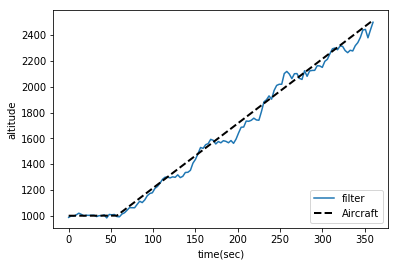

In [23]:
#now plotting
plt.plot(time, xs[:,2], label='filter', )
plt.plot(time, ys, label='Aircraft', lw=2, ls='--', c='k')
plt.xlabel('time(sec)')
plt.ylabel('altitude')
plt.legend(loc=4)